# Load libraries and data

Load libraries

In [17]:
import numpy as np 
import pandas as pd 
import time
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.cluster import KMeans
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=UserWarning)
from pandas.core.common import SettingWithCopyWarning
simplefilter(action="ignore", category=SettingWithCopyWarning)

Load data

In [3]:
X_all_data = pd.read_csv(r'C:\Users\macio\Documents\Python\Data Science\Kaggle_Credit_Fraud_Detection\creditcard.csv')
X_all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# Preprocessing

Check null values

In [4]:
X_all_data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Split data to x and y

In [5]:
y_all_data = X_all_data.Class
X_all_data.drop(['Class'], axis=1, inplace=True)
X_all_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


Check if the data set is balanced or not.

In [6]:
y_all_data.value_counts()

0    284315
1       492
Name: Class, dtype: int64

Split data to train/valid and test set

In [7]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X_all_data, y_all_data, train_size=0.85, test_size=0.15, random_state=1)

Distribution of values in individual columns.

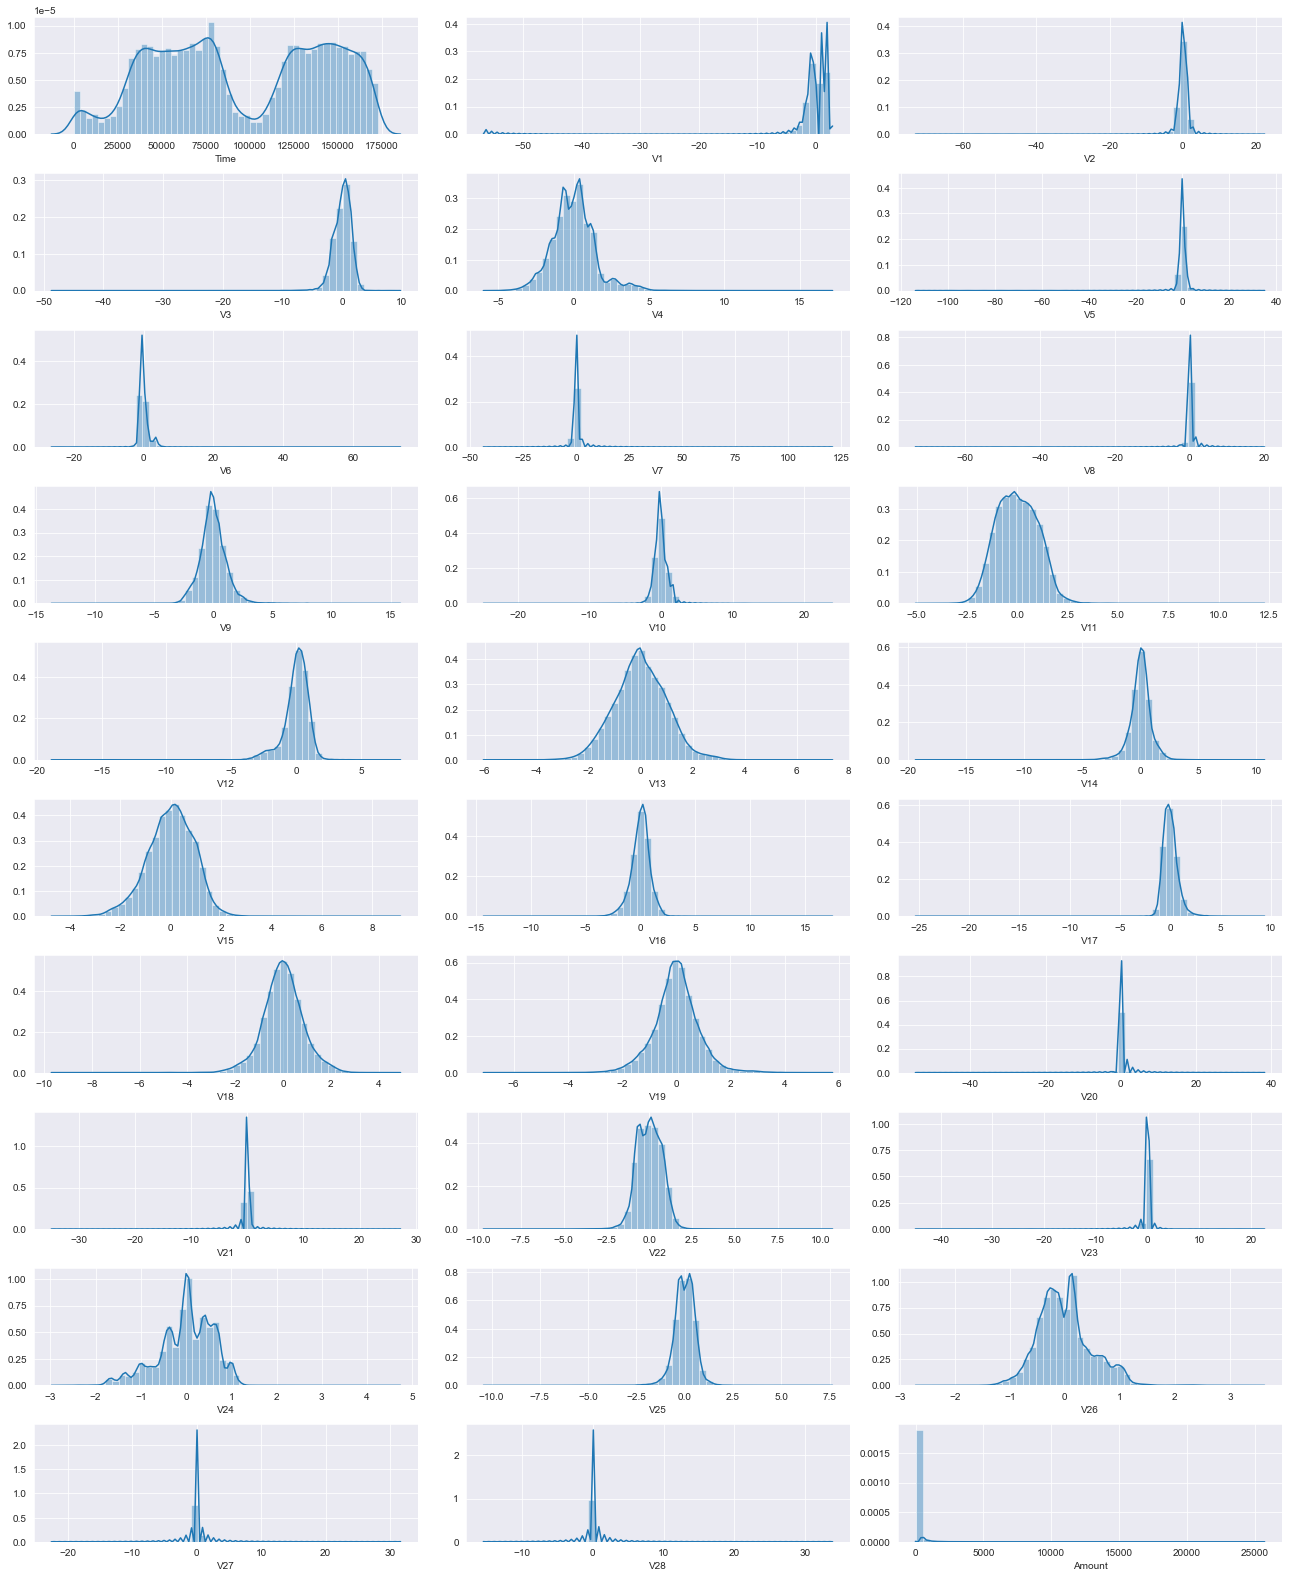

In [10]:
fig = plt.figure(figsize=(18,22))
for index in range(len(X_train_valid.columns)):
    plt.subplot(10,3,index+1)
    sns.distplot(X_train_valid.iloc[:,index].dropna(), norm_hist=False)
fig.tight_layout(pad=1.0)

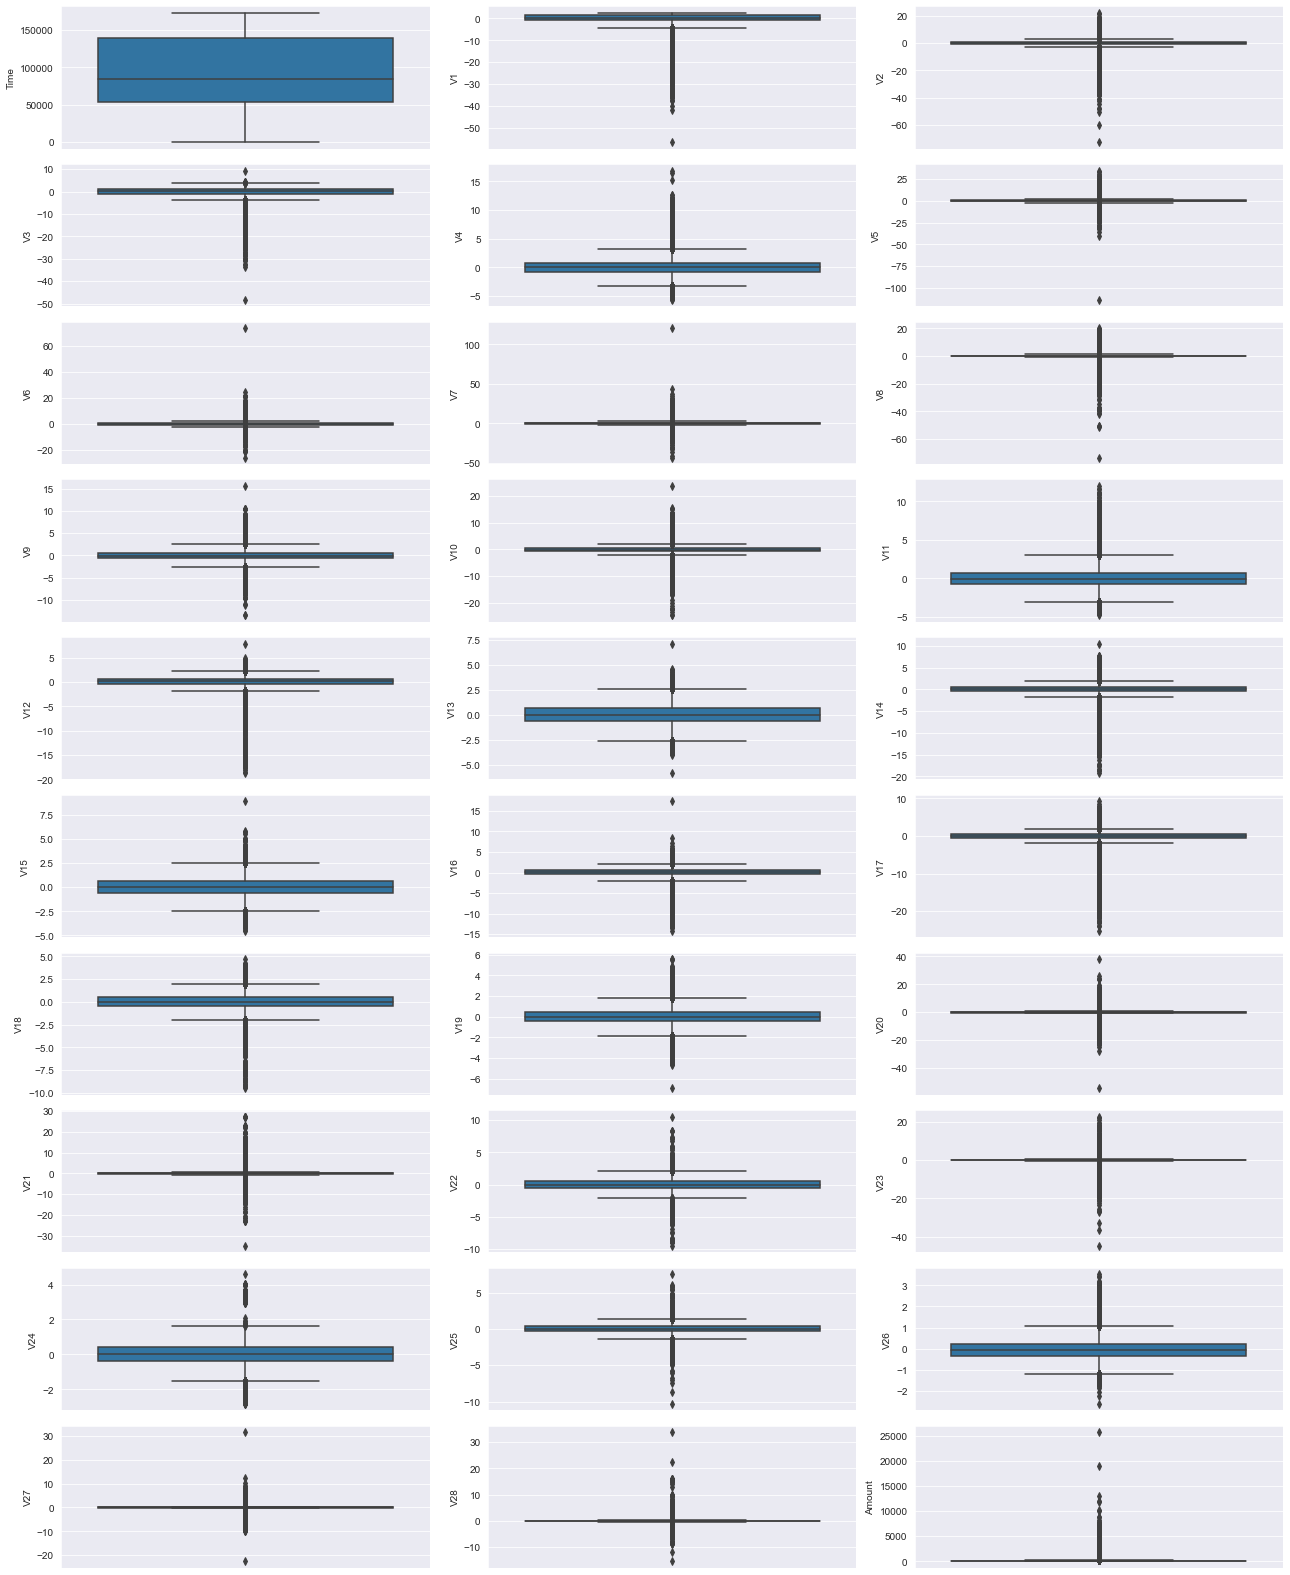

In [12]:
fig = plt.figure(figsize=(18,22))
for index in range(len(X_train_valid.columns)):
    plt.subplot(10,3,index+1)
    sns.boxplot(y=X_train_valid.iloc[:,index], data=X_train_valid.dropna())
fig.tight_layout(pad=1.0)

Correlation between individual features.

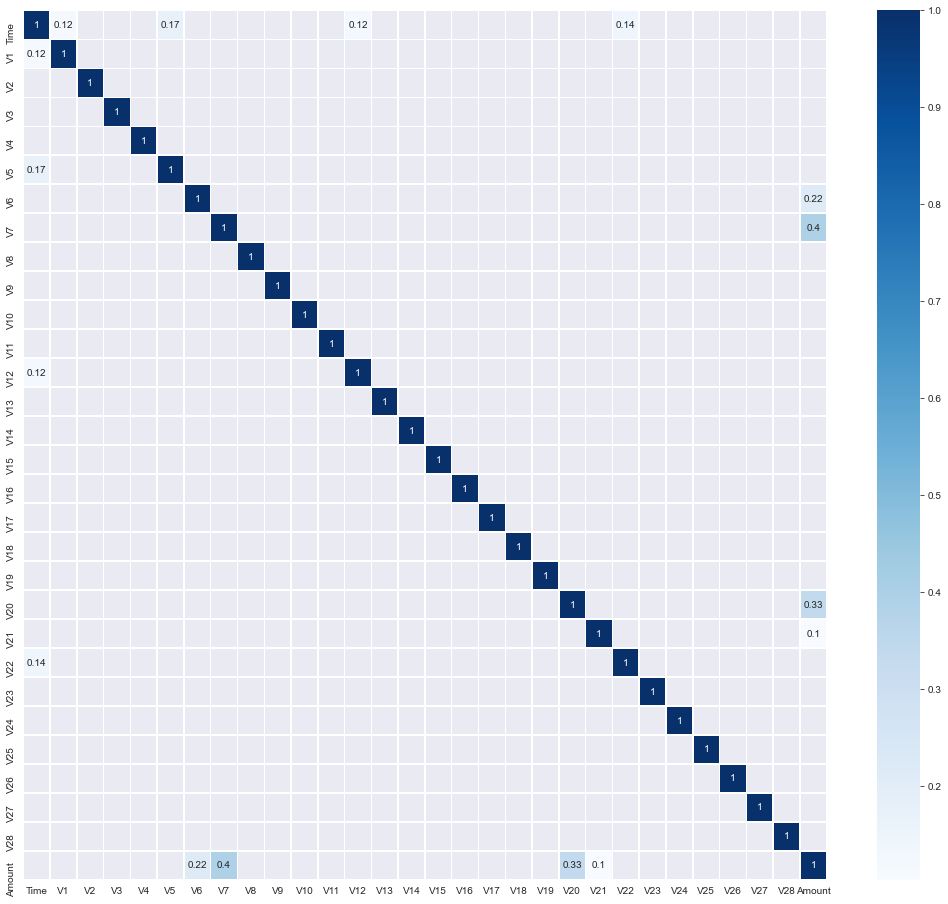

In [14]:
plt.figure(figsize=(18,16))
correlation = X_train_valid.corr()
sns.heatmap(correlation, mask = correlation <0.1, linewidth=0.5, cmap='Blues', annot=True)

Application of the SMOTE algorithm to oversampling an unbalanced data set. Its parameters are listed below, while the algorithm is performed separately for each cross-validation.

In [15]:
sm = SMOTE(sampling_strategy = 0.1, n_jobs=-1, random_state = 1)

Using RobustScaler to reduce the impact of extreme feature values.

# Classification model

Function showing the results of a 5-fold model validation.

In [19]:
def evaluate_model(model, name):
    model_performances = pd.DataFrame({
        'Model' : [name],
        'Mean F1 score(val)' : round(model.cv_results_['mean_test_f1'][model.best_index_], 3),
        'Mean Precision(val)': round(model.cv_results_['mean_test_precision'][model.best_index_], 3),
        'Mean Recall(val)': round(model.cv_results_['mean_test_recall'][model.best_index_], 3),
        'Fit time(val)': round(model.cv_results_['mean_fit_time'][model.best_index_], 3)
    })
    model_performances.set_index('Model', inplace=True, drop=True)
    return model_performances

In [20]:
kf = StratifiedKFold(5, shuffle=True, random_state=1)

Model LightGBM.

In [29]:
start = time.time()

lgbm = Pipeline([
        ('sampling', sm),
        ('scaling', RobustScaler()),
        ('model', LGBMClassifier())
    ])

param_lst_lgbm = {
    'model__max_depth' : [2, 3, 5, 7, 8],
    'model__num_leaves' : [3, 5, 20, 80, 180],
    'model__learning_rate' : [0.001, 0.01, 0.1, 0.2],
    'model__n_estimators' : [100, 300, 500, 1000, 1500, 2000],
    'model__reg_alpha' : [0.001, 0.01, 1, 10, 100],
    'model__reg_lambda' : [0.001, 0.01, 1, 10, 100],
    'model__colsample_bytree' : [0.5, 0.7, 0.8],
    'model__min_child_samples' : [5, 10, 20, 25],
}

lgbm_cv = RandomizedSearchCV(estimator = lgbm,
                              param_distributions = param_lst_lgbm,
                              n_iter = 30,
                              scoring = ['f1', 'precision', 'recall'],
                              refit='f1',
                              cv = kf,
                              n_jobs = -1)
       
lgbm_search = lgbm_cv.fit(X_train_valid, y_train_valid)

best_param_lgbm = lgbm_search.best_params_
end = time.time()
time_lgbm = round(end-start, 0)
print('Dobrane parametry dla modelu LGBM: ', best_param_lgbm)
print('Czas dopierania parametrów: ', time_lgbm, ' [sek]')

Dobrane parametry dla modelu LGBM:  {'model__reg_lambda': 1, 'model__reg_alpha': 0.001, 'model__num_leaves': 180, 'model__n_estimators': 300, 'model__min_child_samples': 5, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.8}
Czas dopierania parametrów:  406.0  [sek]


In [35]:
cv_lgbm = evaluate_model(lgbm_search,  'LGBM')
print(cv_lgbm)

       Mean F1 score(val)  Mean Precision(val)  Mean Recall(val)  \
Model                                                              
LGBM                0.865                0.888             0.844   

       Fit time(val)  
Model                 
LGBM          35.925  


# Results

A function that presents the results of classification on a test set.

In [36]:
def evaluate_model_test(model, X, y, name):
    start = time.time()
    pred = model.predict(X) 
    end = time.time()
    f1_sc = f1_score(y, pred)
    precision_sc = precision_score(y, pred)
    recall_sc = recall_score(y, pred)
    model_performances_test = pd.DataFrame({
        'Model' : [name],
        'F1 score(test)' : round(f1_sc, 3),
        'Precision(test)': round(precision_sc, 3),
        'Recall(test)': round(recall_sc, 3),
        'Predict time' : round(end-start, 4)
    })
    model_performances_test.set_index('Model', inplace=True, drop=True)
    return model_performances_test

Comparison of the results obtained on the test set and on the validation sets.

In [37]:
test_lgbm = evaluate_model_test(lgbm_search, X_test, y_test, 'LGBM')
results_all = pd.concat([cv_lgbm, test_lgbm ], axis=1)
results_all.head()

,Mean F1 score(val),Mean Precision(val),Mean Recall(val),Fit time(val),F1 score(test),Precision(test),Recall(test),Predict time
Model,,,,,,,,
LGBM,0.865,0.888,0.844,35.925,0.827,0.859,0.797,0.1291


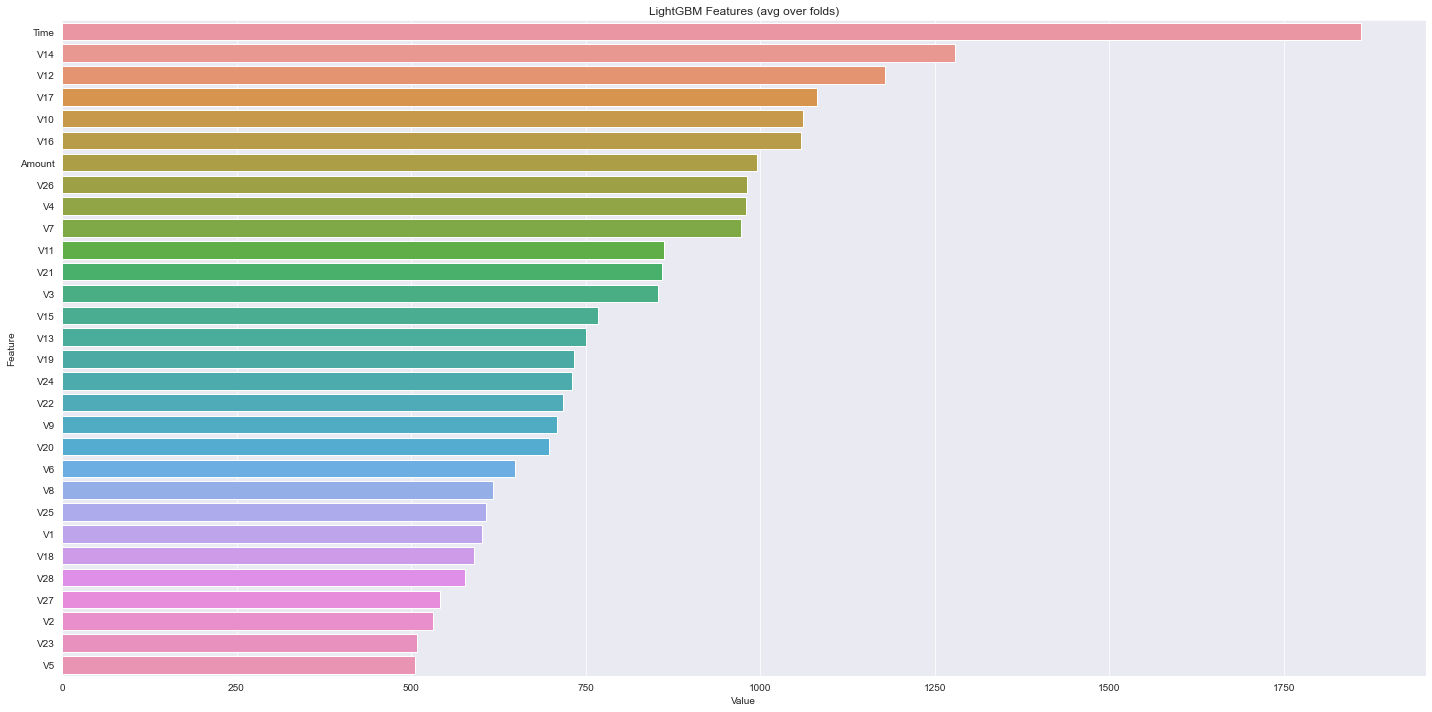

In [38]:
feature_imp = pd.DataFrame(sorted(zip(lgbm_search.best_estimator_.named_steps['model'].feature_importances_,X_test.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()